<a href="https://colab.research.google.com/github/sir-sauc3/Sugarscape-Model/blob/main/Sugarscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FINAL PROJECT: SUGARSCAPE

##Author: Sos

###Introduction:

The Sugarscape experiment is a digital simulation that models the behavior of agents as they search for sugar resources in a finite environment. The environment is represented as a grid, and each cell in the grid could contain a certain amount of sugar. Each agent has their own set of rules for how to search for sugar; they differ in vision, metabolism, and lifespan.

We will shortly discover that as the agents are randomly positioned and start collecting sugar, the sugar becomes scarce and a fierce competition for the remaining resources begins. This leads to the emergence of hierarchies, where the ants with the better vision, metabolism, and lifespan, power over the others.

...

Since this is not code that I am coming up with from scratch, but rather building up on from an existing notebook. With that said, I will take this opportunity to give credit to the original work from chapter 11 of COMP 215 course's textbook. The reason I am making this notebook is so that it can be self-contained and easy to follow.

\

---



The first cell imports all the necessary modules to carry out this simulation while the second cell is from one of my labs. I shall use it when it comes to the point of displaying the data.

In [1]:
import numpy as np
from pprint import pprint
import random

from time import sleep

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
                              cmap='YlOrRd',
                              alpha=0.7,
                              vmax=9, 
                              interpolation='none',
                              origin='lower',
                              )


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = plt.gca()  # If not axes are provided, draw on current axes axes or 
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    return plt.imshow(array, **options)

####The notebook from the textbook does not really say where the `Cell2D` class comes from. Making it difficult to understand what was going on. My task was to try figure out why this class was being called in the code and create one for myself.

####So, here is my take...

What `Cell2D` does here is to make a simple 2D array and fill it in with 0's.

It also has an animation function which is used to plot the figure. As we go through each time step, the figure gets displayed and then cleared using `clear_output()` -- a function from the `IPython.display` module.

In [3]:
class Cell2D:

    def __init__(self, n, m=None):
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)


    def animate(self, frames, interval=None, step=None):
        from IPython.display import clear_output
        if step is None:
            step = self.step
            
        plt.figure()
        try:
            for i in range(frames):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
        except KeyboardInterrupt:
            pass

####The next 5 code cells are what I got from the notebook. They define and set parameters for the Sugarscape model, set rules on how an agent is created, and define other stand-alone functions.

`make_locs()` creates a numpy array containing every possible coordinate of a `n`x`m` grid.

This will be helpful later when we are creating agents and want to get a place to position them.

In [4]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

`make_visible_locs()` generates an array of visible cells for an agent, which is based on the agent's visual range. The array is constructed using `make_array()` that generates visible cells with increasing distance, and the `make_visible_locs()` calls `make_array()` for each distance value and stacks the resulting arrays together to form the final kernel of visible cells.

`.vstack()` is used to stack arrays in a vertical fashion. It takes a sequence of arrays (`arrays`) as input and returns a single array that stacks the input arrays vertically.

In [5]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

`distance_from()` is a function that uses two numpy array functions:

1.   `np.indices()` returns two index arrays of size `n` each :-

*   The first one (which is assigned to `X`) is a numpy array of all 0's in the first row, all 1's in the second row , ... , and all `n`'s in the `n`th row. You can think of this as an array of horizontal indices where each value just states the row index it is in.
*   The second one (which is assigned to `Y`) is a numpy array that contains `[0, 1, 2 , 3 , ... , (n-1) , n]` in all its `n` rows; when printed, `Y` is seen as an array with all 0's in its first column, all 1's in its second column, ... , and all `n`'s in its `n`th column. You can think of this as an array of vertical indices where each value just states the column index it is in.


2.   `np.hypot()` creates an array of size `n`. When printed out, the values shown represent the Euclidean distance from position (`i` , `j`) to that cell. You can think of this as an array that shows the distance from cell (`i` , `j`) to every other cell in the `n` x `n` grid.

In [6]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

The `Agent` class has some pretty straight forward functions, so I'll just go on to explain lines 13 through 24 in the `__init__()` function. 

Remember when I mentioned that agents differ in vision, metabolism, and lifespan? That is what gets done here.

1.   Lines 13 - 18 are responsible for setting the limits for our agents' attributes. This is achieved using `param.get()` . Since `param` is a dictionary that may or may not be passed during the creation of a Sugarscape instance, `.get()` checks through the dictionary for keys that are identical to its first argument. If it finds that key, it returns its value and the code assigns it to a variable. If the key does not exist, the second parameter of `.get()` gets returned. For example, in the first case, `params.get()` looks for `max_vision` in the `params` dictionary. If it exists, the value associated to the key `max_vision` gets returned and assigned to the variable `max_vision`. Otherwise, 6 is returned.

2.   For each agent that gets created, lines 21 - 24 pick what values to assign to its attributes. This is done using `np.random()` which is a function that creates an equally likely chance of picking any element from a range of elements. The differnce here is that line 21 is the only one to have `.randint()` while the others have `.uniform()`. This simply means that we want some attributes to only be integers while others can be floating point numbers (set to a default of 15 decimal places). If you would like to change it to 2 decimal places, include `dtype=np.float16` as a third argument in any `.uniform()` function.

In [7]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

There's a whole lot going on in the Sugarscape class. Some methods are self explanatory so I will try to expound on the functions that need a bit more explaining.


*   `make_capacity()` creates an array that shows how good each cell in a grid is for an agent to move to. It does this by measuring the distance from two important cells in the grid (the two peaks at (`15,15`) and (`35,35`) respectively). It then puts each cell into one of four groups based on its distance from the peak spots. The function then returns the array that shows which group each cell belongs to. The closer a cell is to one of the peaks, the better it is for the agent to move towards it.


*   `make_agents()` uses the `make_locs()` function that I explained earlier.


*   `look_and_move()` helps the agents move to a cell in a grid that has the most sugar. It takes the coordinates of the cell they are currently in, as well as a maximum distance they can see (their vision). Then, it finds all the cells that are within that maximum distance using `make_visible_locs()` , and checks if each one is unoccupied. If all of the visible cells are occupied, the agent stays where it is. Otherwise, the agent looks up how much sugar there is in each empty cell and moves to the one with the most sugar. If there is a tie between two cells with the same amount of sugar, it picks the one that is closest.




*   `step()` simulates one time step in the simulation. It starts by checking if the `replace` parameter is set to `True`, which means that if an agent dies, a new one will be added to the grid. Then, the function loops through all the agents in random order and performs the following actions:

    1. Removes the agent's current cell from the list of occupied cells
    
    2. Executes one step for the agent by calling `agent.step()`
    
    3. If the agent is dead (either from starvation or old age) , `self.agents.remove(agent)` removes if from the list of agents, and if the `replace` parameter is set to `True`, a new agent is added to the grid using `self.add_agent()`
    
    4. If the agent is not dead, its current cell is added back to the list of occupied cells

    After all the agents have been moved, the function appends the current number of agents to a time series list, and then calls `grow()` , which regenerates some sugar on the grid. Finally, the function returns the current number of agents.






In [8]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        plot_2D_array(self.array, title = 'Sugarscape Model', **DEFAULT_IMSHOW_OPTIONS)
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

####Now that all the classes, methods, and functions have been defined, we can run and test the simulation.

The frame below shows the initial state of the simulation. All the agents are in random positions. The frame also includes two concentric circles whose shade fades away the further you move from their centers. The darker the cell, the more the sugar it contains.

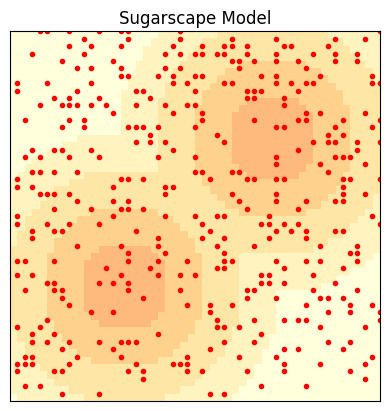

In [9]:
env = Sugarscape(50, num_agents=400)
env.draw()

After running the simulation for long enough (`frames=300`) , we get so see the state of the simulation at that time step. Almost all the agents are concentrated around either one of the important cells (peaks) that I mentioned before.

By this point, it becames clear that only the most adapted and resilient agents were able to survive in the harsh environment. The weaker members of the population were quickly eliminated, leaving only the 'fittest' to continue on and thrive -- ouch!

Over time, natural selection favored those agents with advantageous traits, and the population evolved to become more and more well-suited to their environment. 

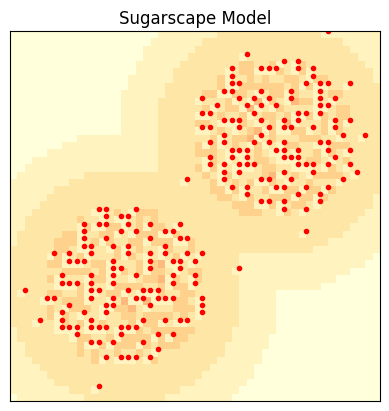

In [10]:
env.animate(frames=300)

In [16]:
print(f'Number of agents by the last time step comes to: {len(env.agents)} agents')

Number of agents by the last time step comes to: 239 agents




---


From the block below, we can tell the number of agents present across all time steps. What's interesting about this graph is that in the first few time steps as the population rapidly decreases and heads to zero, an interesting observation is made that the agent population decreases less rapidly to remain constant at about the 50th time step. At this point, there is no drastic change in the population size of the agents and it remains that way for the entirety of the simulation.

What does this mean to us as computational scientists? From the graph we can tell that the simulation is heavy-tailed, giving hints that it exhibits self-regulating criticality. Self-regulating criticality refers to the phenomenon where complex systems can spontaneously evolve towards a state where they exhibit a balance between stability and instability, resulting in a scale-invariant behavior. Due to the different attributes that the agents had when being created, the 'highly active' agents (those with better vision, better metabolism and a longer lifespan) far surpassed the 'less active' agents and begun to dominate that environment.

What could be done farther from this step is to introduce a change into the envionment (like changing the rate at which sugar comes back) and observing what changes it brings to the agent population. Does it arrive at a new steady state? Does it go back to exhibiting self-regulating criticality?

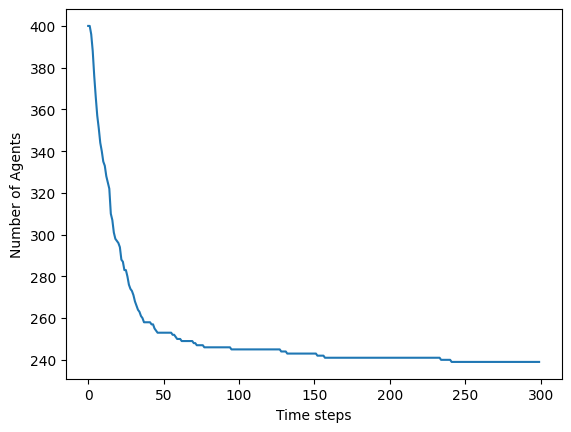

In [17]:
plt.gca().set(xlabel=('Time steps'), ylabel=('Number of Agents'))
plt.plot(env.agent_count_seq)